# Importing the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preprocessing

### Importing the Database

In [2]:
filename = 'ml_datasource.csv'
raw_data = pd.read_csv(filename)
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [8]:
data = raw_data.copy()
data

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0
...,...,...,...,...,...,...,...,...
17756,EG,0,0.8,1,0,0,0.00,0
17757,IN,0,0.1,1,0,0,0.00,0
17758,CM,0,7.8,1,0,0,0.00,0
17759,CA,0,10.4,1,0,0,0.00,0


### Removing Outliers

In [9]:
sns.set()

<Axes: xlabel='minutes_spent_on_exams', ylabel='Density'>

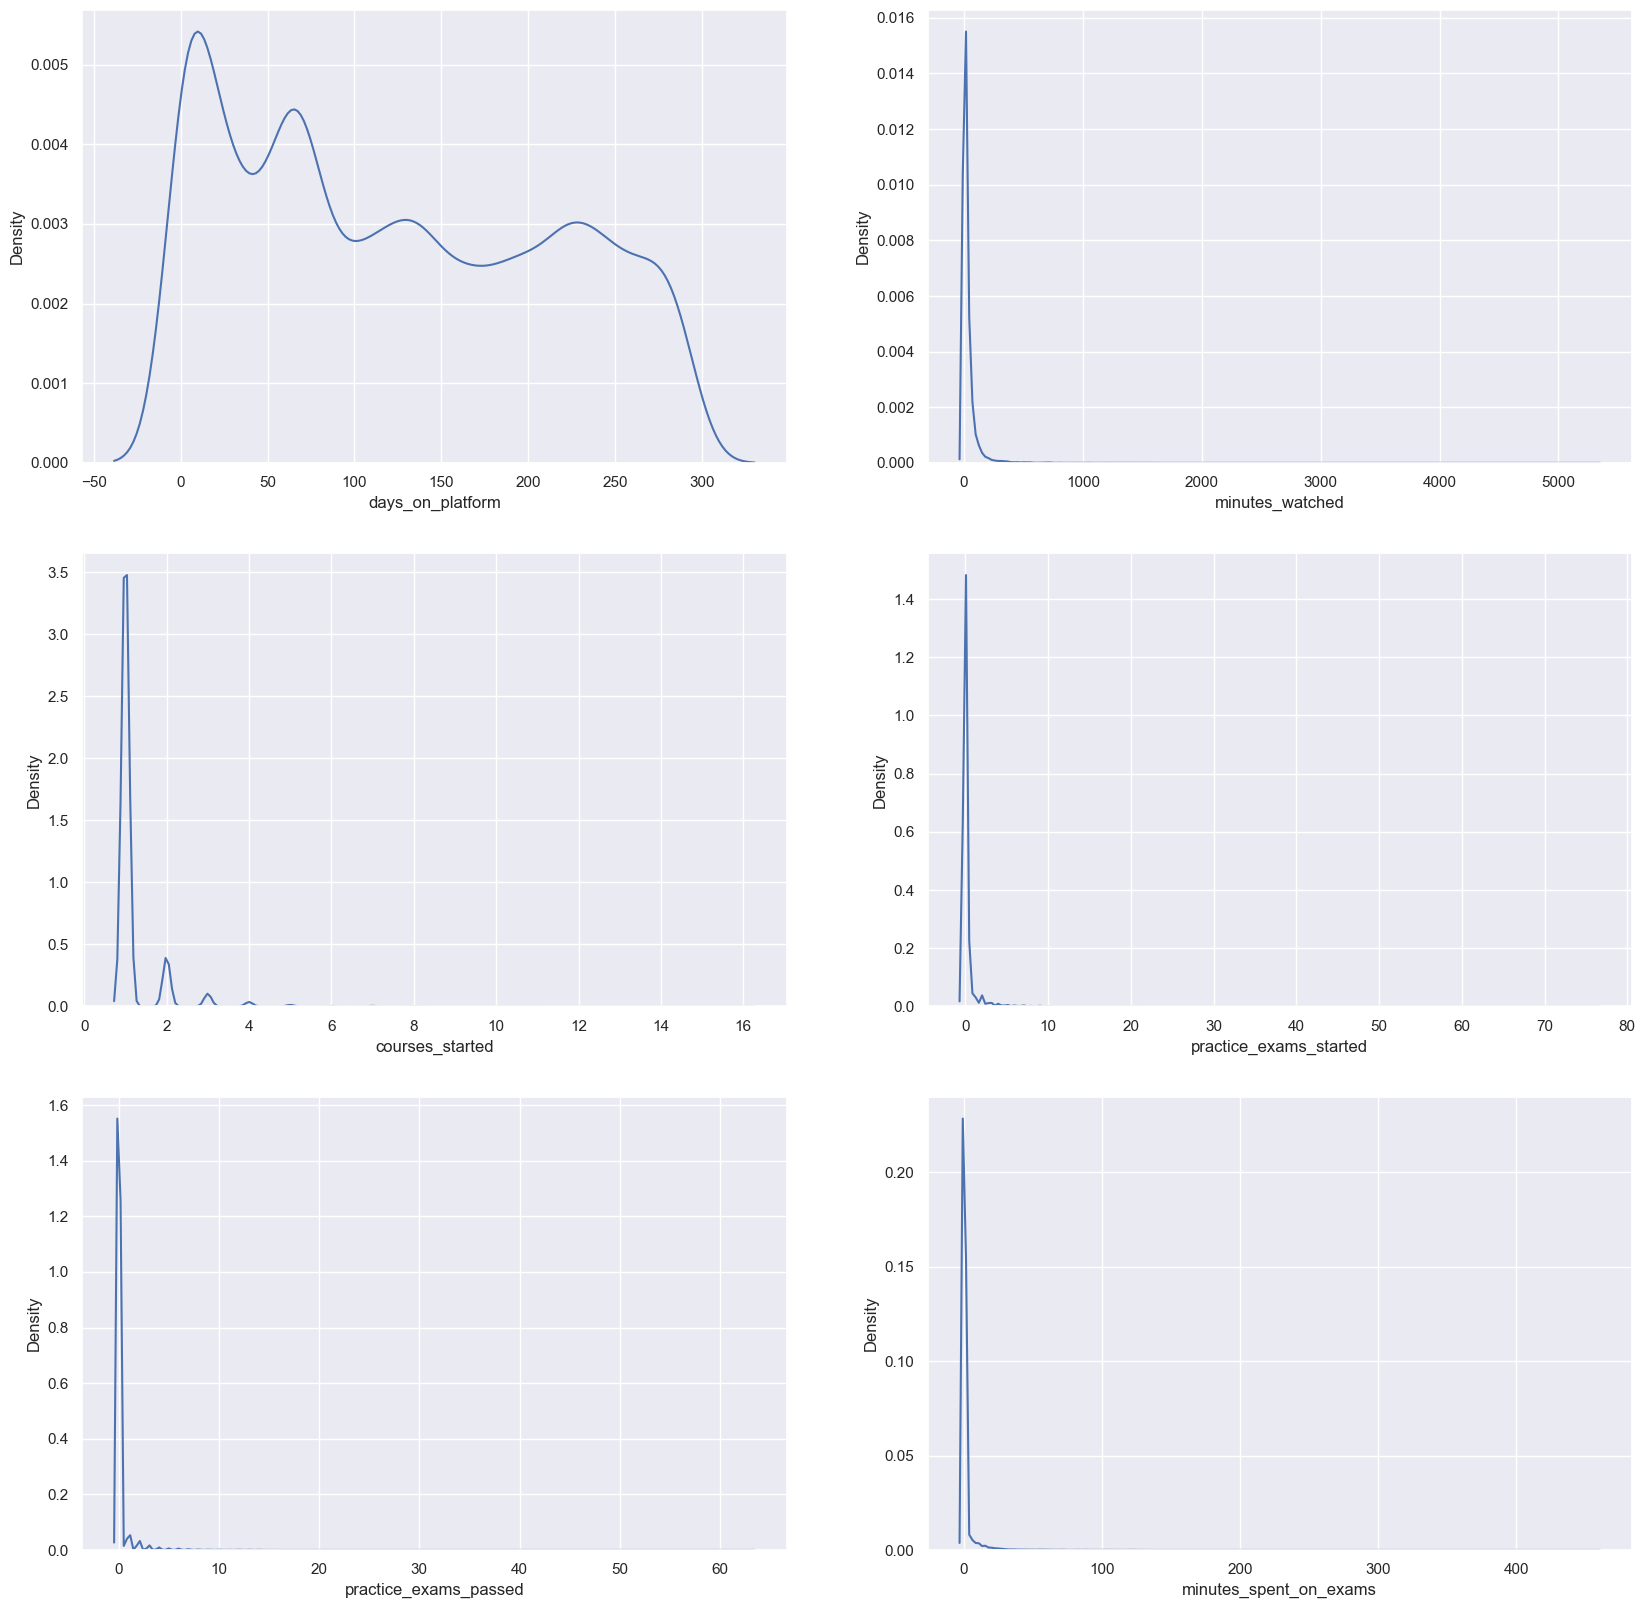

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
sns.kdeplot(data = data, x='days_on_platform', ax=axes[0,0])
sns.kdeplot(data = data, x='minutes_watched', ax=axes[0,1])
sns.kdeplot(data = data, x='courses_started', ax=axes[1,0])
sns.kdeplot(data = data, x='practice_exams_started', ax=axes[1,1])
sns.kdeplot(data = data, x='practice_exams_passed', ax=axes[2,0])
sns.kdeplot(data = data, x='minutes_spent_on_exams', ax=axes[2,1])

### Checking for Multicollinearity

### Dealing with NaN Values

### Splitting the Data

### Encoding the Data

# Creating a Logistic Regression Model

# Creating a K-Nearest Neighbors Model

# Creating a Support Vector Machines Model

# Creating a Decision Trees Model

# Creating a Random Forests Model